In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
from PyDSTool import Par,Var,args, Generator, ContClass, pointset_to_traj, Pointset
from time import process_time as clock

# Analisando sistemas dinâmicos com o PyDSTool
A biblioteca PyDSTool contém várias ferramentas para análise de sistemas dinâmicos incluindo a construção de diagramas de bifurcação.

O Pydstool pode ser instalado via pip:
```
pip install pydstool
```
o código fonte com diversos exemplos de uso encontra-se no [Github](https://github.com/robclewley/pydstool/tree/master/examples)

## Modelo predador presa 4D
O modelo é um modelo predador presa de Rosenzweig-MacArthur, com duas sub-populações.

\begin{align*} 
v_1' &= v_1\left(1-\frac{v_1}{k}\right) - \frac{v_1 p_1}{(1+h v_1)} \\ 
v_2' &= v_2 \left(1-\frac{v_2}{k}\right) - \frac{v_2 p_2}{(1+h v_2)} \\ 
p_1' &= -1 \mu p_1 + \frac{v_1 p_1}{(1+h v_1)} + D \left[\left(\frac{(1+\theta h v_2)}{(1+h v_2)}\right) p_2 - \left(\frac{(1+\theta h v_1)}{(1+h v_1)}\right) p_1\right] \\ 
p_2' &= -1 \mu p_2 + \frac{v_2 p_2}{(1+h v_2)} + D \left[\left(\frac{(1+\theta h v_1)}{(1+h v_1)}\right) p_1 - \left(\frac{(1+\theta h v_2)}{(1+h v_2)}\right) p_2\right] 
\end{align*}

In [23]:
# Declare names and initial values for (symbolic) parameters
mu = Par(0.8, 'mu')
k = Par(7, 'k')
D = Par(0.5, 'D')
theta = Par(1, 'theta')
h = Par(0.5, 'h')

# Compute nontrivial boundary equilibrium initial condition from parameters (see reference for derivation)
v1_0 = mu*(2*D + mu) / (D*(1-h*mu-theta*h*mu) + mu*(1-h*mu))
v2_0 = 0.0
p1_0 = (1+h*v1_0)*(1-v1_0/k)
p2_0 = (D/(D+mu))*(1+theta*h*v1_0)*(1-v1_0/k)

# Declare symbolic variables
v1 = Var('v1')
v2 = Var('v2')
p1 = Var('p1')
p2 = Var('p2')

# Create Symbolic Quantity objects for definitions
v1rhs = v1*(1-v1/k) - v1*p1/(1+h*v1)
v2rhs = v2*(1-v2/k) - v2*p2/(1+h*v2)
p1rhs = -1*mu*p1 + v1*p1/(1+h*v1) + D*(((1+theta*h*v2)/(1+h*v2))*p2 - ((1+theta*h*v1)/(1+h*v1))*p1)
p2rhs = -1*mu*p2 + v2*p2/(1+h*v2) + D*(((1+theta*h*v1)/(1+h*v1))*p1 - ((1+theta*h*v2)/(1+h*v2))*p2)

# Build Generator
DSargs = args(name='PredatorPrey')
DSargs.pars = [mu, k, D, theta, h]
DSargs.varspecs = args(v1=v1rhs,
                       v2=v2rhs,
                       p1=p1rhs,
                       p2=p2rhs)
# Use eval method to get a float value from the symbolic definitions given in
# terms of parameter values
DSargs.ics = args(v1=v1_0.eval(), v2=v2_0, p1=p1_0.eval(), p2=p2_0.eval())
ode = Generator.Vode_ODEsystem(DSargs)

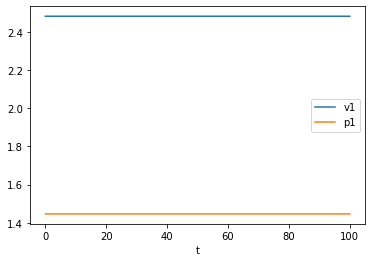

In [28]:
ode.set(tdata=[0,100])
traj = ode.compute('Exemplo')
pts = traj.sample()
plt.plot(pts['t'], pts['v1'], label='v1')
plt.plot(pts['t'], pts['p1'], label='p1')
plt.legend()
plt.xlabel('t');

Computing curve...
Checking...
  |q| = 1.000000
  |<p,q> - 1| =  1.1102314949223176e-16
  |Aq - iwq| = 0.000000
  |A*p + iwp| = 0.000000

H Point found 
0 : 
p1  =  1.478415090015924
p2  =  0.5686211884676631
v1  =  2.4827586206896552
v2  =  0.0
k  =  7.2936628700558765

Eigenvalues = 

     (-0.000000,0.537392)
     (-0.000000,-0.537392)
     (-1.467390,0.000000)
     (0.431379,0.000000)


w = 0.5373921552564828
l1 = -0.00018478323732232932

done in 3.267 seconds!
Computing Hopf curve...
ZH Point found 
0 : 
p1  =  1.7156914765210558
p2  =  1.0000000021490956
v1  =  3.451702898245245
v2  =  -1.5732814882515794e-25
k  =  9.314197357168144
D  =  1.1178001001357456
_k  =  0.22064685431715172

Eigenvalues = 

     (-2.541392,0.000000)
     (-0.000000,0.469731)
     (-0.000000,-0.469731)
     (-0.000000,0.000000)


done in 32.265 seconds!


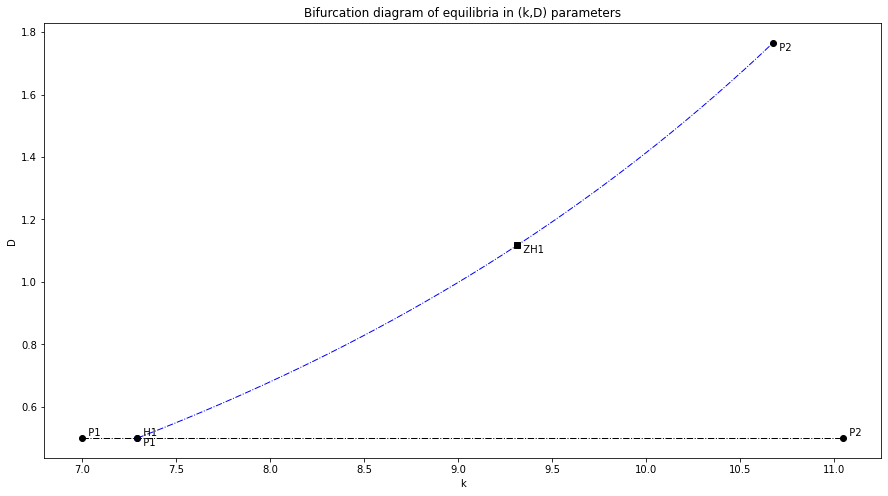

In [29]:
# Set up continuation class
PC = ContClass(ode)

PCargs = args(name='EQ1', type='EP-C')
PCargs.freepars = ['k']
PCargs.StepSize = 1e-2
PCargs.MaxNumPoints = 50
PCargs.MaxStepSize = 1e-1
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.verbosity = 2
PC.newCurve(PCargs)

print ('Computing curve...')
start = clock()
PC['EQ1'].forward()
print ('done in %.3f seconds!' % (clock()-start))

PCargs.name = 'HO1'
PCargs.type = 'H-C2'
PCargs.initpoint = 'EQ1:H1'
PCargs.freepars = ['k','D']
PCargs.MaxNumPoints = 50
PCargs.MaxStepSize = 0.1
PCargs.LocBifPoints = ['ZH']
PCargs.SaveEigen = True
PC.newCurve(PCargs)

print ('Computing Hopf curve...')
start = clock()
PC['HO1'].forward()
print ('done in %.3f seconds!' % (clock()-start))

PCargs = args(name = 'FO1', type = 'LP-C')
PCargs.initpoint = 'HO1:ZH1'
PCargs.freepars = ['k','D']
PCargs.MaxNumPoints = 25
PCargs.MaxStepSize = 0.1
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PC.newCurve(PCargs)

# Plot bifurcation diagram
fig,ax = plt.subplots(1,figsize=(15,8))
PC.display(('k','D'), stability=True,axes=ax, figure=1)
plt.title('Bifurcation diagram of equilibria in (k,D) parameters');

### Soluções emanando a partir de um ponto de Bifurcação Hopf

In [33]:
# D value increases monotonically with k, so let's find the value at k=9.0
# by linear interpolation from the points found by PyCont
hopfs_unparam = PC['HO1'].sol[['D','v1','v2','p1','p2']]
hopfs = Pointset(indepvararray=PC['HO1'].sol['k'], indepvarname='k',
                 coorddict=hopfs_unparam.todict())
ix0, ix1 = hopfs.find(9)
print("k values found around 9.0 are %.3f, %.3f" % ( hopfs['k'][ix0], hopfs['k'][ix1] ))

# Arbitrarily choose closest lower index to check stability
print("Hopf point found for k = %.3f is stable?" % hopfs['k'][ix0], end=' ')
if PC['HO1'].sol[ix0].labels['H']['stab'] == 'N':
    print("No")
else:
    print("Yes")

k values found around 9.0 are 8.988, 9.071
Hopf point found for k = 8.988 is stable? No


In [34]:
# Create interpolatable curve from the pointset
hopfs_curve = pointset_to_traj(hopfs)
# Interpolate unstable Hopf equilibrium values of parameters/variables at k=9
Hpt = hopfs_curve(9.0)

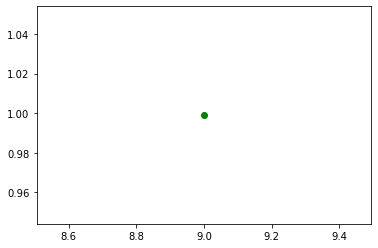

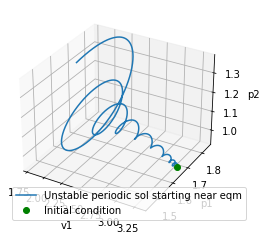

In [35]:
# extract the variables defined for 'ode' Generator
Hics = Hpt[ode.funcspec.vars]
# perturb slightly off equilibrium
Hics['v2'] += 0.01
# extract the parameter value for D and indicate on bifurcation diagram
plt.plot(9.0, Hpt['D'], 'go')

ode.set(tdata=[0,100],
        pars={'k': 9.0, 'D': Hpt['D']},
        ics=Hics)
traj = ode.compute('test')
pts = traj.sample()

fig = plt.figure()
try:
    ax = fig.gca(projection='3d')
except ValueError:
    # pre-v1.0 version of Matplotlib
    ax = Axes3D(fig)
ax.plot(pts['v1'], pts['p1'], pts['p2'],
        label='Unstable periodic sol starting near eqm')
# to ensure your version accepts singleton points, enclose in extra brackets!
ax.plot(pts[[0]]['v1'], pts[[0]]['p1'], pts[[0]]['p2'], 'go', label='Initial condition')
ax.legend()
ax.set_xlabel('v1')
ax.set_ylabel('p1')
ax.set_zlabel('p2')
# 3D projection (v1,p1,p2) of unstable periodic sol. starting near eqm.
plt.draw()

In [16]:
PC.info()

ContClass of model PredatorPrey
Containing curves: 
  EQ1 (type EP-C)
  HO1 (type H-C2)
  FO1 (type LP-C)
